In [1]:
!pip install flash-attn transformers accelerate termcolor altair

import time
from datetime import timedelta

import torch
import torch.nn.functional as F
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers.utils import is_flash_attn_2_available

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2",
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
streamer = TextStreamer(tokenizer, skip_prompt=True)z

print("flash_attn_2 available:", is_flash_attn_2_available())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


flash_attn_2 available: True


In [2]:
def gen(text, preview=True):
    duration_start = time.perf_counter()
    prompt = "<|user|>\n{} <|end|>\n<|assistant|>".format(text)
    tokens = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        tokens,
        max_new_tokens=1024,
        return_dict_in_generate=True,
        streamer=streamer if preview else None,
    )
    output_tokens = outputs.sequences[0]
    output_gen_tokens = output_tokens[
        len(tokens[0]) : -1
    ]  # From just after prompt to just before <|end|> token
    output_string = tokenizer.decode(output_gen_tokens)
    duration_seconds = time.perf_counter() - duration_start
    if preview:
        print(
            "== took {} ({} toks: {}/tok; {} tps) ==".format(
                timedelta(seconds=duration_seconds),
                len(output_gen_tokens),
                timedelta(seconds=duration_seconds / len(output_gen_tokens)),
                len(output_gen_tokens) / duration_seconds,
            )
        )
        print()
    del tokens, outputs, output_tokens, output_gen_tokens
    return output_string


def embed(text, mean_layers=False, mean_tokens=False, prompt_prefix=""):
    duration_start = time.perf_counter()
    prompt = "{}{}".format(prompt_prefix, text)
    tokens = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    outputs = model(tokens, output_hidden_states=True)
    embedding = outputs.hidden_states
    # print(len(embedding), embedding[0].shape)
    if mean_layers:
        # print(torch.stack(embedding).shape)
        embedding = torch.stack(embedding).mean(dim=0)  # Mean layers
    else:
        embedding = embedding[-1]  # Take last layer

    if mean_tokens:
        embedding = embedding.mean(dim=1)  # Mean tokens
    else:
        embedding = embedding[:, -1, :]  # Take last token

    embedding = embedding[0]  # Take first and only element of batch

    embedding_cpu = embedding.to("cpu").detach()
    del tokens, outputs, embedding
    return embedding_cpu

In [4]:
def D(obj):
    if isinstance(obj, tuple):
        print(len(obj))
    elif isinstance(obj, torch.Tensor):
        print(obj.shape)
        display(obj)

In [5]:
text = 'Write a haiku about symmetry.'
prompt = "<|user|>\n{} <|end|>\n<|assistant|>".format(text)
inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
outputs = model(**inputs)

You are not running the flash-attention implementation, expect numerical differences.


In [6]:
# (BATCH_SIZE, NUM_TOKENS, VOCAB_SIZE)
outputs.logits.shape

torch.Size([1, 12, 32064])

In [7]:
logits = outputs.logits[0, -1, :]
D(logits)

torch.Size([32064])


tensor([5.6875, 6.0312, 3.9375,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [8]:
sorted_logits, sorted_indices = torch.sort(logits, descending=True)
probs = F.softmax(sorted_logits, dim=-1)
cum_probs = torch.cumsum(probs, dim=-1)
D(cum_probs)

torch.Size([32064])


tensor([0.6870, 0.7924, 0.8978,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<CumsumBackward0>)

In [12]:
sorted_keep_indices = cum_probs < 0.9
sorted_keep_indices[1:] = sorted_keep_indices[:-1].clone()
sorted_keep_indices[0] = 1
D(sorted_keep_indices)
sorted_keep_indices.sum()

torch.Size([32064])


tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

tensor(4, device='cuda:0')

In [13]:
keep_indices = sorted_indices[sorted_keep_indices]
D(keep_indices)

torch.Size([4])


tensor([11612,  2431,  7392,  9897], device='cuda:0')

In [14]:
tokenizer.decode(keep_indices)

'Mir Per Bal Ref'

In [15]:
keep_probs = probs[sorted_keep_indices]
D(keep_probs)
keep_probs.sum()

torch.Size([4])


tensor([0.6870, 0.1054, 0.1054, 0.0235], device='cuda:0',
       grad_fn=<IndexBackward0>)

tensor(0.9213, device='cuda:0', grad_fn=<SumBackward0>)

In [18]:
def top_p_tokens(logits, top_p=0.9):
    """Does not support batches yet. logits must be of shape (VOCAB_SIZE)."""
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probs = F.softmax(sorted_logits, dim=-1)
    cum_probs = torch.cumsum(probs, dim=-1)
    sorted_keep_indices = cum_probs < 0.9  # Create tensor of bools indicating which indices are cumulatively less than top_p
    sorted_keep_indices[1:] = sorted_keep_indices[:-1].clone()  # Keep the last element that went over top_p
    sorted_keep_indices[0] = 1  # Always keep the first element
    keep_toks = sorted_indices[sorted_keep_indices]
    keep_probs = probs[sorted_keep_indices]
    return keep_toks, keep_probs

In [46]:
tokenizer.eos_token_id

32000

In [47]:
tokenizer.eos_token

'<|endoftext|>'

In [48]:
tokenizer.encode('<|end|>')

[1, 32007]

In [49]:
from collections import namedtuple
class Candidate(namedtuple('Candidate', ['sequence', 'prob'])):
    pass
    def __repr__(self):
        string = tokenizer.decode(self.sequence[0])
        return f'Candidate [{self.prob}]: {string} \n  ({self.sequence})'

max_candidates = 100
text = 'Write a haiku about symmetry.'
prompt = "<|user|>\n{} <|end|>\n<|assistant|>".format(text)
inputs = tokenizer(prompt, return_tensors='pt').to('cuda')

candidates = [
    Candidate(inputs.input_ids, 1.0)
]

p = 0.99999999
for candidate in candidates:
    print(candidate)
print()
finished = []
# OPTIM: Batch inference, which means rewrite top_p_tokens to use batch
# OPTIM: Keep previous_key values
# OPTIM: Use Tensors to keep track of candidates (with masked values)
# OPTIM: Log probs
for i in tqdm.tqdm(list(range(100))):
    new_candidates = []
    for candidate in candidates:
        outputs = model(input_ids=candidate.sequence)
        new_toks, new_probs = top_p_tokens(outputs.logits[0, -1, :], p)
        for new_tok, new_prob in zip(new_toks, new_probs):                
            new_candidate = Candidate(torch.cat([candidate.sequence, new_tok.unsqueeze(0).unsqueeze(0)], dim=1), candidate.prob * new_prob.item())
            if new_tok == 32000:
                finished.append(new_candidate)
            else:
                new_candidates.append(new_candidate)
    candidates = new_candidates[:max_candidates]
    # print(i, p, len(candidates))
    # for candidate in candidates:
    #     print(candidate)
    # print()
    p *= 0.5

Candidate [1.0]: <s><|user|> Write a haiku about symmetry. <|end|><|assistant|> 
  (tensor([[    1, 32010, 14350,   263,   447, 18282,  1048, 18446, 29889, 29871,
         32007, 32001]], device='cuda:0'))



100%|██████████| 100/100 [07:28<00:00,  4.48s/it]


In [51]:
from sklearn.decomposition import PCA
import pandas as pd
import altair as alt


def graph_embeds(candidates, embed_func):
    idxs = []
    texts = []
    probs = []
    embeds = []
    for idx, candidate in enumerate(candidates):
        idxs.append(idx)
        text = tokenizer.decode(candidate.sequence[0])
        texts.append(text)
        probs.append(candidate.prob)
        embeds.append(embed_func(text))
            
    pca = PCA(n_components=2)
    pca_embeds = pca.fit_transform(torch.stack(embeds).float().numpy())
        
    data = pd.DataFrame({
        'Idx': idxs,
        'Text': texts,
        'Prob': probs,
        'PCA_0': map(lambda p: p[0], pca_embeds),
        'PCA_1': map(lambda p: p[1], pca_embeds),
    })
    
    display(data)
    
    display(alt.Chart(data).mark_point(size=50).encode(
        x='PCA_0',
        y='PCA_1',
        color='Prob',
        tooltip=['Idx', 'Prob', 'Text']
    ).interactive())
    
graph_embeds(candidates, lambda x: embed(x, prompt_prefix=''))
graph_embeds(candidates, lambda x: embed(x, prompt_prefix='What is the format of this text?'))

,Idx,Text,Prob,PCA_0,PCA_1
0,0,<s><|user|> Write a haiku about symmetry. <|en...,1.109705e-15,-15.849360,2.531917
1,1,<s><|user|> Write a haiku about symmetry. <|en...,1.101248e-15,12.540116,11.780823
2,2,<s><|user|> Write a haiku about symmetry. <|en...,1.109628e-15,22.240236,-9.474933
3,3,<s><|user|> Write a haiku about symmetry. <|en...,3.116549e-16,-14.129418,-2.165662
4,4,<s><|user|> Write a haiku about symmetry. <|en...,3.284818e-17,-10.825222,-0.242679
...,...,...,...,...,...
95,95,<s><|user|> Write a haiku about symmetry. <|en...,6.169469e-18,24.113361,-8.737761
96,96,<s><|user|> Write a haiku about symmetry. <|en...,3.741972e-18,6.365707,11.258631
97,97,<s><|user|> Write a haiku about symmetry. <|en...,2.342370e-18,12.373698,14.018184
98,98,<s><|user|> Write a haiku about symmetry. <|en...,1.824240e-18,14.809218,17.934401


alt.Chart(...)

,Idx,Text,Prob,PCA_0,PCA_1
0,0,<s><|user|> Write a haiku about symmetry. <|en...,1.109705e-15,6.876442,-10.058390
1,1,<s><|user|> Write a haiku about symmetry. <|en...,1.101248e-15,-21.768423,-4.344114
2,2,<s><|user|> Write a haiku about symmetry. <|en...,1.109628e-15,-24.729824,-6.964918
3,3,<s><|user|> Write a haiku about symmetry. <|en...,3.116549e-16,13.144187,23.177197
4,4,<s><|user|> Write a haiku about symmetry. <|en...,3.284818e-17,13.914984,19.393843
...,...,...,...,...,...
95,95,<s><|user|> Write a haiku about symmetry. <|en...,6.169469e-18,-23.849773,-6.762807
96,96,<s><|user|> Write a haiku about symmetry. <|en...,3.741972e-18,-13.617752,-6.240834
97,97,<s><|user|> Write a haiku about symmetry. <|en...,2.342370e-18,-20.878899,-7.544504
98,98,<s><|user|> Write a haiku about symmetry. <|en...,1.824240e-18,-14.978434,-4.642626


alt.Chart(...)

100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


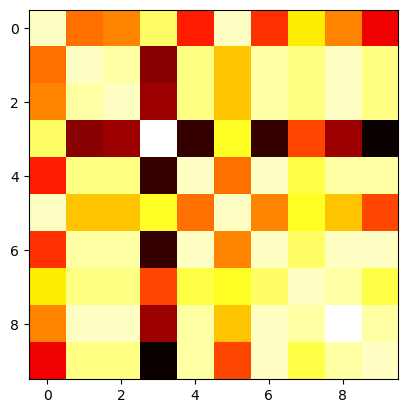

100%|██████████| 10/10 [00:00<00:00, 15.63it/s]


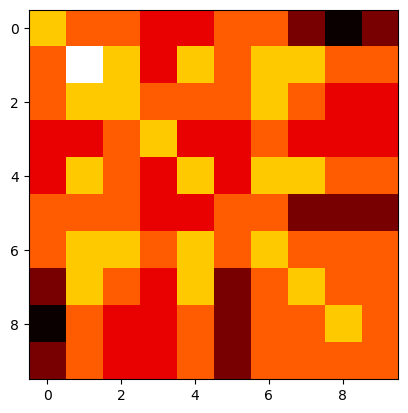

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import tqdm

def embed_matrix(candidates, embed_func):
    embeds = [embed_func(arr_item) for arr_item in tqdm.tqdm(candidates)]

    matrix = np.zeros((len(embeds), len(embeds)))
    cos = nn.CosineSimilarity(dim=0)

    for i in range(len(embeds)):
        for j in range(len(embeds)):
            matrix[i,j] = cos(embeds[i], embeds[j])

    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.show()

embed_matrix(candidates[:10], lambda x: embed(x, prompt_prefix=''))
embed_matrix(candidates[:10], lambda x: embed(x, prompt_prefix='What is the format of this text?'))